<a href="https://colab.research.google.com/github/michalbh/car_object_detection/blob/main/car_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive to Colab

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'kaggle/car_object_detection/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/kaggle/car_object_detection


In [ ]:
print(os.getcwd())

/content/drive/MyDrive/kaggle/car_object_detection


# Imports

In [ ]:
import glob
import torch
import random
from torchvision.ops import nms
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

# For yolov5:
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm
#import wandb
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

from IPython.display import Image, clear_output  # to display images
from os import listdir
from os.path import isfile
from glob import glob
import yaml
# clear_output()

# Loading data

In [ ]:
train_labels_df = pd.read_csv("/content/drive/MyDrive/kaggle/car_object_detection/data/train_solution_bounding_boxes (1).csv")
train_img_path = '/content/drive/MyDrive/kaggle/car_object_detection/data/training_images/'
test_img_path = '/content/drive/MyDrive/kaggle/car_object_detection/data/testing_images/'

In [ ]:
train_labels_df.head(3)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180


In [ ]:
print(train_labels_df.shape)
print(len(train_labels_df['image'].unique()))

(559, 5)
355


vid_4_14160.jpg
image shape is:  (380, 676, 3)


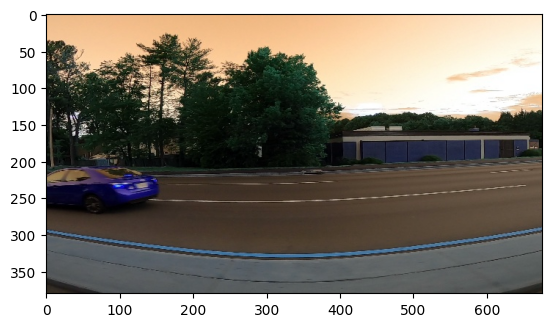

In [ ]:
idx = random.randrange(train_labels_df.shape[0])
print(train_labels_df['image'][idx])
img = cv2.imread(train_img_path+train_labels_df['image'][idx])
# print image shape to understand its resolution and channels:
print("image shape is: ", img.shape)
plt.imshow(img)
#plt.axis("off")

In [ ]:
def display_img_w_bbox(df, image_name, pred_bbox=[]):
    img = cv2.imread(train_img_path+image_name)
    # get images bbox coordinates - note we might have more than one gt bbox per image path:
    img_rows = df.loc[df['image'] == image_name, ['xmin', 'ymin', 'xmax', 'ymax']]
    for idx, row in img_rows.iterrows():
        # draw gt rect using cv2, in green:
        img = cv2.rectangle(img,(int(row['xmin']), int(row['ymin'])),
                            (int(row['xmax']), int(row['ymax'])),(0, 255,0),thickness=2)

    if(len(pred_bbox) > 0):
        # draw pred rect using cv2, in red:
        pass
        #img = cv2.rectangle(img,(int(xmin), int(ymin)), (int(xmax), int(ymax)),(255,0, 0),thickness=2)

    # plot the resulting image with all bboxes:
    plt.imshow(img)

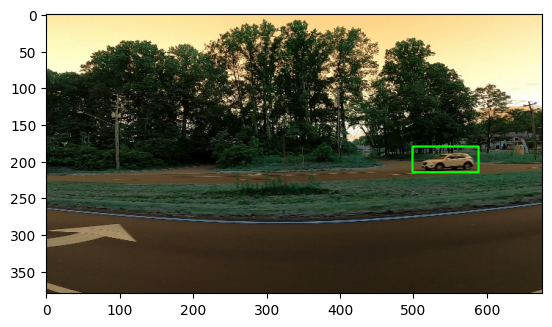

In [ ]:
idx = random.randrange(train_labels_df.shape[0])
display_img_w_bbox(train_labels_df, train_labels_df['image'][idx])

In [ ]:
# get all images resolution:
img = cv2.imread(train_img_path+train_labels_df['image'][0])
img_height, img_width, n_channels = img.shape
print(img_height, img_width, n_channels)


train_labels_df['x_min'] = train_labels_df.apply(lambda row: (row.xmin)/img_width, axis = 1)*float(img_width)
train_labels_df['y_min'] = train_labels_df.apply(lambda row: (row.ymin)/img_height, axis = 1)*float(img_height)
train_labels_df['x_max'] = train_labels_df.apply(lambda row: (row.xmax)/img_width, axis =1)*float(img_width)
train_labels_df['y_max'] = train_labels_df.apply(lambda row: (row.ymax)/img_height, axis =1)*float(img_height)

train_labels_df['x_mid'] = train_labels_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_labels_df['y_mid'] = train_labels_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_labels_df['w'] = train_labels_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_labels_df['h'] = train_labels_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_labels_df['x_mid'] /= float(img_width)
train_labels_df['y_mid'] /= float(img_height)

train_labels_df['w'] /= float(img_width)
train_labels_df['h'] /= float(img_height)


#train_labels_df['x_mid'] = train_labels_df.apply(lambda row: (row.xmax+row.xmin)/2, axis =1)
#train_labels_df['y_mid'] = train_labels_df.apply(lambda row: (row.ymax+row.ymin)/2, axis =1)

#train_labels_df['w'] = train_labels_df.apply(lambda row: (row.xmax-row.xmin), axis =1)
#train_labels_df['h'] = train_labels_df.apply(lambda row: (row.ymax-row.ymin), axis =1)

train_labels_df['class_id'] = 0
train_labels_df.head(3)

380 676 3


,image,xmin,ymin,xmax,ymax,x_min,y_min,x_max,y_max,x_mid,y_mid,w,h,class_id
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0


In [ ]:
# Directory path
train_img_path = '/content/drive/MyDrive/kaggle/car_object_detection/data/training_images/'

# Get a list of all image files in the directory
files = os.listdir(train_img_path)

# Create a DataFrame with the file paths
train_images_df = pd.DataFrame({'image': files})

# Display the DataFrame
print(len(train_images_df['image'].unique()))
print(train_images_df['image'].head(3))

# Split data
train_images_df, val_images_df = train_test_split(train_images_df, test_size=0.2, shuffle=True)

print(f"train: {len(train_images_df)}; valid: {len(val_images_df)};")

1001
0    vid_4_12340.jpg
1    vid_4_11180.jpg
2    vid_4_12420.jpg
Name: image, dtype: object
train: 800; valid: 201;


In [ ]:
TRAIN_LABELS_PATH = '/content/drive/MyDrive/kaggle/car_object_detection/yolo_data/labels/train'
VAL_LABELS_PATH = '/content/drive/MyDrive/kaggle/car_object_detection/yolo_data/labels/val'
TRAIN_IMAGES_PATH = '/content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/train'
VAL_IMAGES_PATH = '/content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/val'

shutil.rmtree(TRAIN_LABELS_PATH, ignore_errors=True)
shutil.rmtree(VAL_LABELS_PATH, ignore_errors=True)
shutil.rmtree(TRAIN_IMAGES_PATH, ignore_errors=True)
shutil.rmtree(VAL_IMAGES_PATH, ignore_errors=True)

os.makedirs(TRAIN_LABELS_PATH, exist_ok = False)
os.makedirs(VAL_LABELS_PATH, exist_ok = False)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = False)
os.makedirs(VAL_IMAGES_PATH, exist_ok = False)

#/kaggle/working/
print(os.listdir('./'))
print(os.listdir('/content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images'))

['data', 'yolo_data', 'yolov5', 'car_object_detection.ipynb']
['train', 'val']


In [ ]:
# <class> <x_center> <y_center> <width> <height>
def preproccess_data(df, labels_path, images_path):
    for column, row in tqdm(df.iterrows(), total=len(df)):
        label_rows = train_labels_df.loc[train_labels_df['image'] == row['image']]
        if (not label_rows.empty):
            for _, label_row in label_rows.iterrows():
                attributes = label_row[['class_id','x_mid','y_mid','w','h']].values
                attributes = np.array(attributes)

                # remove the .jpg from image file name:
                image_filename = row['image']
                image_name_without_extension, _ = os.path.splitext(image_filename)

                # Add ".txt" extension to the image name
                labels_file_path = os.path.join(labels_path, f"{image_name_without_extension}.txt")

                #labels_file_path = os.path.join(labels_path, f"{row['image']}.txt")

                # Open the file in append mode ('a')
                with open(labels_file_path, 'a') as file:
                    # Write the new line to the file without delimiter
                    np.savetxt(file, [attributes], fmt='%f', delimiter=' ', newline='')

                # Add a newline character at the end to separate lines
                with open(labels_file_path, 'a') as file:
                    file.write('\n')

        # copy the image to its relevant path
        shutil.copy(os.path.join('/content/drive/MyDrive/kaggle/car_object_detection/data/training_images', f"{row['image']}"),images_path)

In [ ]:
preproccess_data(train_images_df, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
preproccess_data(val_images_df, VAL_LABELS_PATH, VAL_IMAGES_PATH)

100%|██████████| 201/201 [00:02<00:00, 75.76it/s]


In [ ]:
print(f"Number of files in {TRAIN_LABELS_PATH}: {len(os.listdir(TRAIN_LABELS_PATH))}")
print(f"Number of files in {VAL_LABELS_PATH}: {len(os.listdir(VAL_LABELS_PATH))}")
print(f"Number of files in {TRAIN_IMAGES_PATH}: {len(os.listdir(TRAIN_IMAGES_PATH))}")
print(f"Number of files in {VAL_IMAGES_PATH}: {len(os.listdir(VAL_IMAGES_PATH))}")

#print(os.listdir('/kaggle/working/yolo_data/labels/val'))

# we should have only 355 label files (with total of 559 bboxes inside all of them)
print("number of label files %i" %(len(os.listdir(TRAIN_LABELS_PATH))+len(os.listdir(VAL_LABELS_PATH))))


idx = random.randrange(len(os.listdir(VAL_LABELS_PATH)))

# Open the file in read mode
with open(os.path.join(VAL_LABELS_PATH, f"{os.listdir(VAL_LABELS_PATH)[idx]}"), 'r') as file:
    # Read the entire content of the file and print
    print(file.read())

Number of files in /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/labels/train: 286
Number of files in /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/labels/val: 69
Number of files in /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/train: 800
Number of files in /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/val: 201
number of label files 355
0.000000 0.220685 0.556873 0.196650 0.139896
0.000000 0.362709 0.554930 0.096140 0.081606
0.000000 0.833576 0.518661 0.182811 0.123057



In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
print(os.listdir('./'))

['data', 'yolo_data', 'yolov5', 'car_object_detection.ipynb']


In [ ]:
classes = [ 'car']

data = dict(
    train =  TRAIN_IMAGES_PATH,
    val   =  VAL_IMAGES_PATH,
    nc    = 1,
    names = classes
    )

with open('/content/drive/MyDrive/kaggle/car_object_detection/yolov5/car_od.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('/content/drive/MyDrive/kaggle/car_object_detection/yolov5/car_od.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- car
nc: 1
train: /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/train
val: /content/drive/MyDrive/kaggle/car_object_detection/yolo_data/images/val



In [ ]:
%cd ./yolov5
!pip install -U -r requirements.txt
!pip install pycocotools>=2.0 seaborn>=0.11.0 pandas thop
#clear_output()

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/kaggle/car_object_detection/yolov5


# Training the model

In [ ]:
!python train.py --batch 16 --epochs 15 --data ./car_od.yaml --cfg models/yolov5l.yaml --weights yolov5l.pt --cache --name car_od

In [ ]:
#runs/train/car_od4
print(os.getcwd())

/content/drive/MyDrive/kaggle/car_object_detection/yolov5


In [ ]:
#print(os.listdir('./'))

test_dir = test_img_path
weights_dir = './runs/train/car_od4/weights/best.pt'
os.listdir('./runs/train/car_od4/weights')
print(test_dir)

/content/drive/MyDrive/kaggle/car_object_detection/data/testing_images/


# Running inference on test

In [ ]:
!python detect.py --weights $weights_dir\
--conf 0.15\
--iou 0.4\
--source $test_dir\
--save-txt --save-conf --exist-ok